In [1]:
#Moving to working directory
%cd /content/drive/Shared\ drives/CS230 
%cd google_action_recognition_trial

/content/drive/Shared drives/CS230
/content/drive/Shared drives/CS230/google_action_recognition_trial


In [2]:
#importing necessary libraries
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv3D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Reshape,AveragePooling3D, Bidirectional, LSTM, TimeDistributed, Lambda, Concatenate
from keras.models import Model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils import plot_model
from keras.initializers import VarianceScaling
from keras.backend import mean
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import os

from scipy.special import softmax
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
#function for getting one hot labels
def to_one_hot(labels):
  output = np.zeros(( np.size(labels),6 ))
  label_dict = {'backhand':0,'forehand':1, 'bvolley':2, 'fvolley':3, 'smash':4, 'service':5}
  for n in np.arange(np.size(labels)):
    label = labels[n]
    output[n, label_dict[label]] = 1
  return output 

In [0]:
#Functions for creating dataset - test train and validation from h5 files
import csv

def create_data(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1

  with h5py.File(dataset+'.hdf5', 'w') as f:
    write_data = f.create_dataset('X', np.shape(data))
    write_data[:] = data 

def load_labels(dataset='train',size=20):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return to_one_hot(labels)

def load_data(size_whole,dataset='train'):
  with h5py.File(dataset+'.hdf5', 'r') as f:
    data = np.array(f['X'])
    size = data.shape[0]
  labels_one_hot = load_labels(dataset=dataset,size=size)

  return data[:size_whole], labels_one_hot[:size_whole]


def create_small_dataset(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1
  return data, to_one_hot(labels)

In [0]:
#Creating the datasets
X_train, Y_train = load_data(size_whole=1584,dataset='train')
X_val, Y_val = load_data(size_whole=204,dataset='validation')
X_test, Y_test = load_data(size_whole=192,dataset='test')

In [6]:
# Train network
dropout_rate=0.3
m=0.1
def model_instance(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv3D(128,kernel_size=(1,7,7), padding='valid',kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal'))(X_input)
  #,kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal')  
  X = Reshape((128,))(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(128)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(64)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(32)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  preds = Activation("softmax")(X)
  model = Model(inputs=X_input, outputs=X)
  return model 
model = model_instance(input_shape=(1,7,7,2046))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 7, 7, 2046)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 1, 128)      12832640  
_________________________________________________________________
reshape_1 (Reshape)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_____

In [7]:
#loading the weights and compiling the model
opt=Adam(lr=0.01)
model.load_weights(os.path.join('Checkpoints','weights_model_0_dr03_m1_new.hdf5'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
#Probabilities of prediction
Y_probs_1=model.predict(X_test)

In [9]:
#calculating actual prediction and accuracy
Y_pred_1=softmax(Y_probs_1,axis=-1)
Y_fortesting=np.argmax(Y_pred_1,axis=-1)
accuracy_score(np.argmax(Y_test,axis=1),Y_fortesting)

0.7760416666666666

In [0]:
#Functions for generating data from dataset 1
def to_one_hot(labels):
  output = np.zeros(( np.size(labels),6 ))
  label_dict = {'backhand':0,'forehand':1, 'bvolley':2, 'fvolley':3, 'smash':4, 'service':5}
  for n in np.arange(np.size(labels)):
    label = labels[n]
    output[n, label_dict[label]] = 1
  return output 

import csv

def create_data(dataset='train',size=198):
  data = np.zeros([size,1,7,7,2048])
  labels = []
  with open('evanet/data/data_file_1.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/1/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2048)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1

  with h5py.File(dataset+'_1.hdf5', 'w') as f:
    write_data = f.create_dataset('X', np.shape(data))
    write_data[:] = data 

def load_one_hot_labels(dataset='train',size=198):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return to_one_hot(labels)

def load_text_labels(dataset='train',size=198):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return labels

def load_data(dataset='train', size=198):
  with h5py.File(dataset+'_1.hdf5', 'r') as f:
    data = np.array(f['X'])[0:size]
    default_size = data.shape[0]
  labels_one_hot = load_one_hot_labels(dataset=dataset,size=size)

  return data, labels_one_hot


def create_small_dataset(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2048])
  labels = []
  with open('evanet/data/data_file_1.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/1/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2048)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1
  return data, to_one_hot(labels)

In [0]:
#dataset 1 sets
X_train_1, Y_train_1 = load_data(size=1584,dataset='train')
X_val_1, Y_val_1 = load_data(size=204,dataset='validation')
X_test_1, Y_test_1 = load_data(size=192,dataset='test')

In [13]:
Y_test_1.shape

(192, 6)

In [0]:
# Train network
dropout_rate=0.3
m=0.01
def model_instance(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv3D(128,kernel_size=(1,7,7), padding='valid',kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal'))(X_input)
  X = Reshape((128,))(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(128)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(64)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(32)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  preds = Activation("softmax")(X)
  model = Model(inputs=X_input, outputs=X)
  return model 

In [15]:
model_1 = model_instance(input_shape=(1,7,7,2048))
model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 7, 7, 2048)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 1, 1, 128)      12845184  
_________________________________________________________________
reshape_2 (Reshape)          (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1651

In [17]:
#loading weights and calculating accuracy
opt=Adam()
model_1.load_weights(os.path.join('Checkpoints','weights_dataset1_dr03_m001_newer.hdf5'))
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_1.evaluate(X_train_1,Y_train_1))
print(model_1.evaluate(X_val_1,Y_val_1))
print(model_1.evaluate(X_test_1,Y_test_1))

1584/1584 [==============================] - 1s 320us/step
[16.11809539794922, 1.0]
204/204 [==============================] - 0s 266us/step
[15.1013438093896, 0.8333333333333334]
192/192 [==============================] - 0s 226us/step
[14.551452000935873, 0.78125]


In [0]:
#Getting probs
Y_probs_1_1=model_1.predict(X_test_1)

In [0]:
#Calculating average of two probabilities for ensembling
Y_whole=0.5*(Y_probs_1+Y_probs_1_1)

In [22]:
#calculating accuracy of ensembling
Y_pred_whole=softmax(Y_whole,axis=-1)
Y_fortesting_whole=np.argmax(Y_pred_whole,axis=-1)
accuracy_score(np.argmax(Y_test,axis=1),Y_fortesting_whole)

0.8177083333333334

In [23]:
target_names = ['backhand', 'forehand', 'bvolley', 'fvolley', 
                   'smash', 'service']
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(np.argmax(Y_test,axis=1), Y_fortesting_whole, target_names=target_names))
conf_matrix = confusion_matrix(np.argmax(Y_test,axis=1), Y_fortesting_whole)

              precision    recall  f1-score   support

    backhand       0.86      0.92      0.89        48
    forehand       0.78      0.90      0.83        48
     bvolley       1.00      0.75      0.86        16
     fvolley       1.00      0.31      0.48        16
       smash       0.71      0.31      0.43        16
     service       0.77      1.00      0.87        48

    accuracy                           0.82       192
   macro avg       0.86      0.70      0.73       192
weighted avg       0.83      0.82      0.80       192



In [0]:
#matrix for changing base of shots in confmatrix
testing_matrix=np.array([[1,0,0,0,0,0],[0,0,1,0,0,0],[0,1,0,0,0,0],[0,0,0,1,0,0],[0,0,0,0,0,1],[0,0,0,0,1,0]])

In [0]:
#changing base in conf matrix
conf_matrix_new=np.dot(np.dot(testing_matrix,conf_matrix),testing_matrix.T)

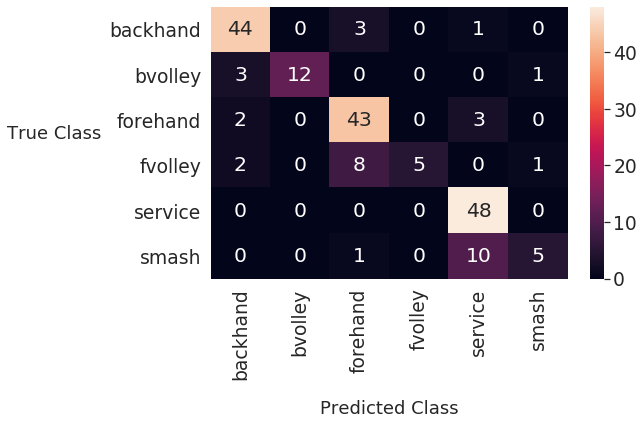

In [52]:
#printing and saving conf matrix
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.7)
target_names_modified = ['backhand', 'bvolley', 'forehand', 'fvolley', 
                   'service', 'smash']
df_cm = pd.DataFrame(conf_matrix_new, index = [i for i in target_names_modified],
                  columns = [i for i in target_names_modified])
plt.figure(figsize = (8,5))
ax = sns.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
plt.savefig('confusion_matrix_ensemble_old.jpg', bbox_inches = 'tight')
plt.show()

#New Model for Data 1

In [53]:
# Train network
dropout_rate=0.3
m=0.01
def model_instance(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv3D(32,kernel_size=(1,7,7), padding='valid',kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal'))(X_input)
  #,kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal')  
  X = Reshape((32,))(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  X = BatchNormalization(momentum=m)(X)
  """
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(64)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(32)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  """
  preds = Activation("softmax")(X)
  model = Model(inputs=X_input, outputs=X)
  return model 
model_1_1 = model_instance(input_shape=(1,7,7,2048))
model_1_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 7, 7, 2048)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 32)       3211296   
_________________________________________________________________
reshape_3 (Reshape)          (None, 32)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
activation_11 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198 

In [0]:
opt=Adam(lr=0.01)
model_1_1.load_weights(os.path.join('Checkpoints','shallow_model_1_final_d03m01.hdf5'))
model_1_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
Y_probs_1_1_new=model_1_1.predict(X_test_1)

In [0]:
Y_whole_new=0.5*(Y_probs_1+Y_probs_1_1_new)

In [57]:
Y_pred_whole_new=softmax(Y_whole_new,axis=-1)
Y_fortesting_whole_new=np.argmax(Y_pred_whole_new,axis=-1)
accuracy_score(np.argmax(Y_test,axis=1),Y_fortesting_whole_new)

0.84375

In [58]:
target_names = ['backhand', 'forehand', 'bvolley', 'fvolley', 
                   'smash', 'service']
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(np.argmax(Y_test,axis=1), Y_fortesting_whole_new, target_names=target_names))
conf_matrix = confusion_matrix(np.argmax(Y_test,axis=1), Y_fortesting_whole_new)

              precision    recall  f1-score   support

    backhand       0.92      0.92      0.92        48
    forehand       0.83      0.90      0.86        48
     bvolley       0.82      0.88      0.85        16
     fvolley       0.82      0.56      0.67        16
       smash       0.67      0.50      0.57        16
     service       0.85      0.92      0.88        48

    accuracy                           0.84       192
   macro avg       0.82      0.78      0.79       192
weighted avg       0.84      0.84      0.84       192



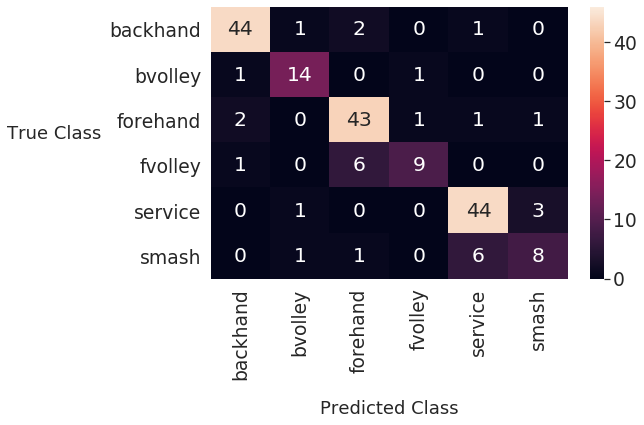

In [63]:
conf_matrix_new=np.dot(np.dot(testing_matrix,conf_matrix),testing_matrix.T)
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.7)
df_cm = pd.DataFrame(conf_matrix_new, index = [i for i in target_names_modified],
                  columns = [i for i in target_names_modified])
plt.figure(figsize = (8,5))
ax = sns.heatmap(df_cm, annot=True, vmin=0, vmax=46)
ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
plt.savefig('confusion_matrix_ensemble_new.png', bbox_inches = 'tight')
plt.show()